# **AlexNet challenge (TensorFlow)**
_Felipe Andres Castillo_




In [ ]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers

GPUs = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs disponibles: ", GPUs)
# Imprime información de la GPU
if GPUs:
    print("TensorFlow está usando la GPU ")
else:
    print("TensorFlow no está usando la GPU")

Num GPUs disponibles:  1
TensorFlow está usando la GPU 


# Modelo 1: AlexNet modificado
Se utilizan las imágenes con su tamaño original (32x32); esto implica modificar los inputs y outputs de algunas capas del modelo original.

## 1. Los datos

El conjunto de datos CIFAR-10 consta de 60 000 imágenes en color de 32 x 32 en 10 clases, con 6000 imágenes por clase. Hay 50 000 imágenes de entrenamiento y 10 000 imágenes de prueba.

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10 000 imágenes. El lote de prueba contiene exactamente 1000 imágenes seleccionadas aleatoriamente de cada clase. Los lotes de entrenamiento contienen las imágenes restantes en orden aleatorio, pero algunos lotes de entrenamiento pueden contener más imágenes de una clase que de otra. Entre ellos, los lotes de entrenamiento contienen exactamente 5000 imágenes de cada clase.

In [ ]:
# Cargar datos
cifar10 = tf.keras.datasets.cifar10

# Conjuntos de entrenamiento y prueba (imagenes y etiquetas)
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Las imagenes son arrays de 32x32, con 3 canales de color
print("train images: ", train_images.shape)
print("train labels: ", train_labels.shape)
print("test images: ", test_images.shape)
print("test labels: ", test_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
train images:  (50000, 32, 32, 3)
train labels:  (50000, 1)
test images:  (10000, 32, 32, 3)
test labels:  (10000, 1)


In [ ]:
# Los labels son números, donde cada uno representa una clase.
# En este caso, los conjuntos labels son arrays de arrays, por lo que se han de transformar en un array de enteros
print("Antes: ", train_labels)
train_labels = train_labels.squeeze()
test_labels_2 = test_labels.squeeze()
print("Después: ", train_labels)

Antes:  [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Después:  [6 9 9 ... 9 1 1]


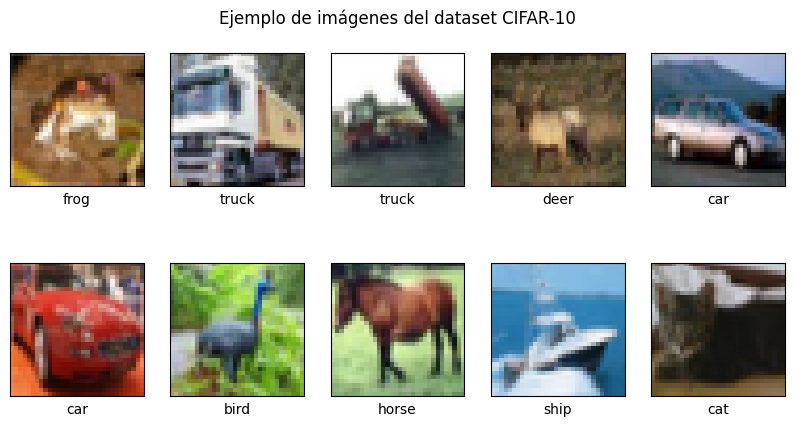

In [ ]:
# Las diez diferentes clases del dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Ejemplo de las imagenes del dataset
plt.figure(figsize=(10,5))
plt.title("Ejemplo de imágenes del dataset CIFAR-10")
plt.axis('off')
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = train_images[i]
    label = train_labels[i]
    plt.imshow(image)
    plt.xlabel(classes[label])
plt.show()

In [ ]:
# Normalización de las imágenes
# train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
# test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encoding para las etiquetas
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels_2, 10)

## 2. El modelo

El modelo original de AlexNet contempla que las imágenes utilizadas tienen dimensiones de 224x224. En este caso al ser imágenes mucho más pequeñas, y por consiguiente, para evitar errores en el procesamiento en cada capa, se elimina el stride = 4 en la primera capa convolucional. También se modifican los inputs y outputs de las capas densas para que coincidan con la salida de la ultima capa convolucional y su posterior _aplanamiento_.

In [ ]:
# Definición del modelo
model_1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(filters=96, kernel_size=11, activation="relu"),
    layers.ZeroPadding2D(padding=(2,2)),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(filters=256, kernel_size=5, padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(filters=384, kernel_size=3, padding='same', activation="relu"),
    layers.Conv2D(filters=384, kernel_size=3, padding='same', activation="relu"),
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 22, 22, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,539,786 (17.32 MB)

 Trainable params: 4,539,786 (17.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Se compila el modelo
model_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 3. Entrenamiento

In [ ]:
num_epochs = 15
batch_size = 64

# Entrenamiento
start_time = timeit.default_timer()
history = model_1.fit(train_images, train_labels, epochs = num_epochs, batch_size = batch_size, validation_split = 0.1)
end_time = timeit.default_timer()
print("Fin del entrenamiento")
traintime_v1 = end_time - start_time
print(f"Tiempo total de entrenamiento: {traintime_v1:.2f} segundos")

# Registro de los valores de accuracy y loss por cada epoca
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.1021 - loss: 2.3069 - val_accuracy: 0.0976 - val_loss: 2.3030
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.1002 - loss: 2.3030 - val_accuracy: 0.0976 - val_loss: 2.3032
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.1007 - loss: 2.3029 - val_accuracy: 0.0976 - val_loss: 2.3027
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.0998 - loss: 2.3027 - val_accuracy: 0.1038 - val_loss: 2.3028
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.0998 - loss: 2.3027 - val_accuracy: 0.0958 - val_loss: 2.3028
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.0985 - loss: 2.3027 - val_accuracy: 0.0950 - val_loss: 2.3028
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.0998 - loss: 2.3027 - val_accuracy: 0.0950 - val_loss: 2.3028
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.0962 - loss: 2.3028 - 

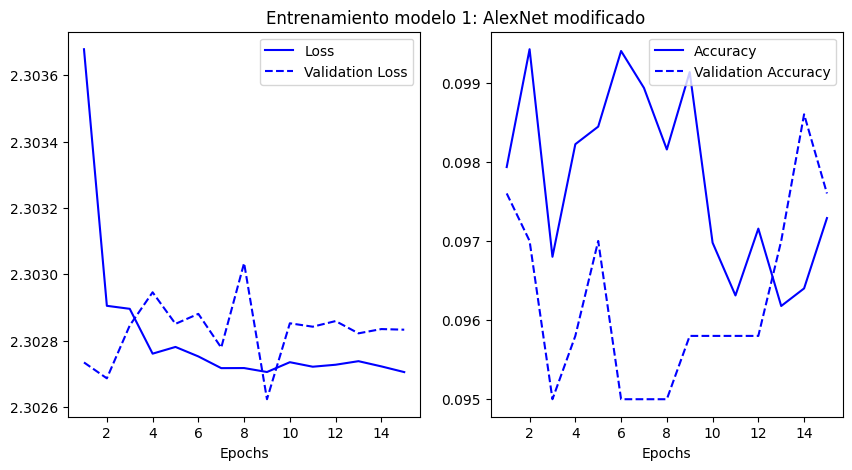

In [ ]:
epochs = range(1,num_epochs+1)

plt.figure(figsize=(10,5))
plt.title("Entrenamiento modelo 1: AlexNet modificado")
plt.axis('off')
plt.subplot(1,2,1)
plt.plot( epochs, loss,  "b-", label="Loss")
plt.plot( epochs, val_loss, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot( epochs, acc, "b-", label="Accuracy")
plt.plot( epochs, val_acc, "b--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# Se guardan los pesos
model_1.save(".\w_modelo_1.keras")

## 4. Evaluación


In [ ]:
# Una vez recargado la arquitectura del modelo, se cargarían los pesos
#modelo_.load(".\w_modelo_1.keras")

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T1, acc_T1 = model_1.evaluate(test_images, test_labels)
print(f"Loss: {loss_T1:.6f}, Accuracy: {100. * acc_T1:.2f}%")

Evaluación del modelo en el conjunto de prueba
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1036 - loss: 2.3026
Loss: 2.302629, Accuracy: 10.00%


In [ ]:
# Predicciones por clase
y_pred = model_1.predict(test_images)
class_pred = np.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels_2, class_pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


# Modelo 2: AlexNet from scratch

Reescanlando el tamaño de las imágenes a 224x224 y definiendo el modelo con los parámetros originales en cada capa.

## 1. Los datos

En este caso, vale lo que ya se tiene del modelo anterior. El cambio de tamaño se incluirá en el modelo.

## 2. El modelo

In [ ]:
# Definición del modelo
model_2 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Resizing(224, 224),
    layers.Conv2D(filters=96, kernel_size=11, strides=4 ,activation="relu"),
    layers.ZeroPadding2D(padding=(2,2)),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(filters=256, kernel_size=5, padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(filters=384, kernel_size=3, padding='same', activation="relu"),
    layers.Conv2D(filters=384, kernel_size=3, padding='same', activation="relu"),
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Flatten(),
    layers.Dense(4096, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4096, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 58, 58, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,322,314 (222.48 MB)

 Trainable params: 58,322,314 (222.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Se compila el modelo
model_2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 3. Entrenamiento

In [ ]:
num_epochs = 15
batch_size = 64

# Entrenamiento
start_time = timeit.default_timer()
history = model_2.fit(train_images, train_labels, epochs = num_epochs, batch_size = batch_size, validation_split = 0.1)
end_time = timeit.default_timer()
print("Fin del entrenamiento")
traintime_v2 = end_time - start_time
print(f"Tiempo total de entrenamiento: {traintime_v2:.2f} segundos")

# Registro de los valores de accuracy y loss por cada epoca
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 91ms/step - accuracy: 0.2587 - loss: 2.0328 - val_accuracy: 0.4116 - val_loss: 1.5742
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.4606 - loss: 1.4830 - val_accuracy: 0.5154 - val_loss: 1.3384
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.5262 - loss: 1.3182 - val_accuracy: 0.5394 - val_loss: 1.2660
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.5680 - loss: 1.2078 - val_accuracy: 0.5698 - val_loss: 1.2094
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.6026 - loss: 1.1156 - val_accuracy: 0.6164 - val_loss: 1.0951
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.6240 - loss: 1.0605 - val_accuracy: 0.6188 - val_loss: 1.1009
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.6537 - loss: 0.9760 - val_accuracy: 0.6254 - val_loss: 1.0706
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.6697 - loss: 0.9279 - 

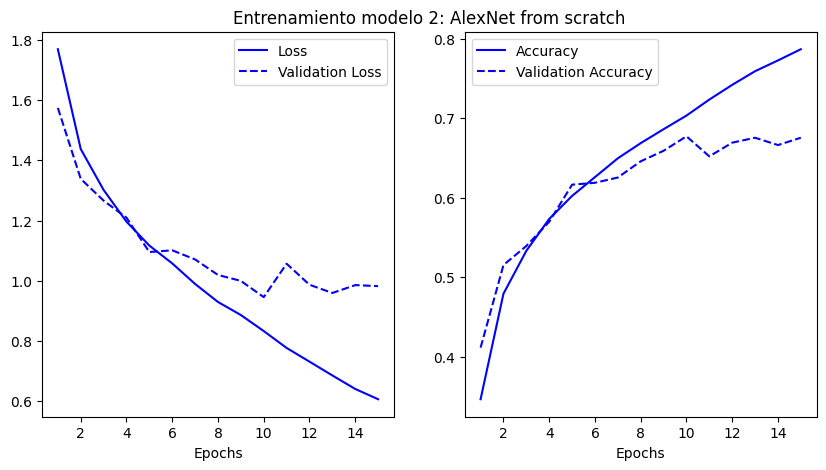

In [ ]:
epochs = range(1,num_epochs+1)

plt.figure(figsize=(10,5))
plt.title("Entrenamiento modelo 2: AlexNet from scratch")
plt.axis('off')
plt.subplot(1,2,1)
plt.plot( epochs, loss,  "b-", label="Loss")
plt.plot( epochs, val_loss, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot( epochs, acc, "b-", label="Accuracy")
plt.plot( epochs, val_acc, "b--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# Se guardan los pesos
model_2.save("/content/drive/My Drive/w_modelo_2.keras")

## 4. Evaluación

In [ ]:
#modelo_.load(".\w_modelo_2.keras")

In [ ]:
print("Evaluación del modelo en el conjunto de prueba")
loss_T2, acc_T2 = model_2.evaluate(test_images, test_labels)
print(f"Loss: {loss_T2:.6f}, Accuracy: {100. * acc_T2:.2f}%")

Evaluación del modelo en el conjunto de prueba
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6651 - loss: 1.0190
Loss: 1.019877, Accuracy: 66.48%


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


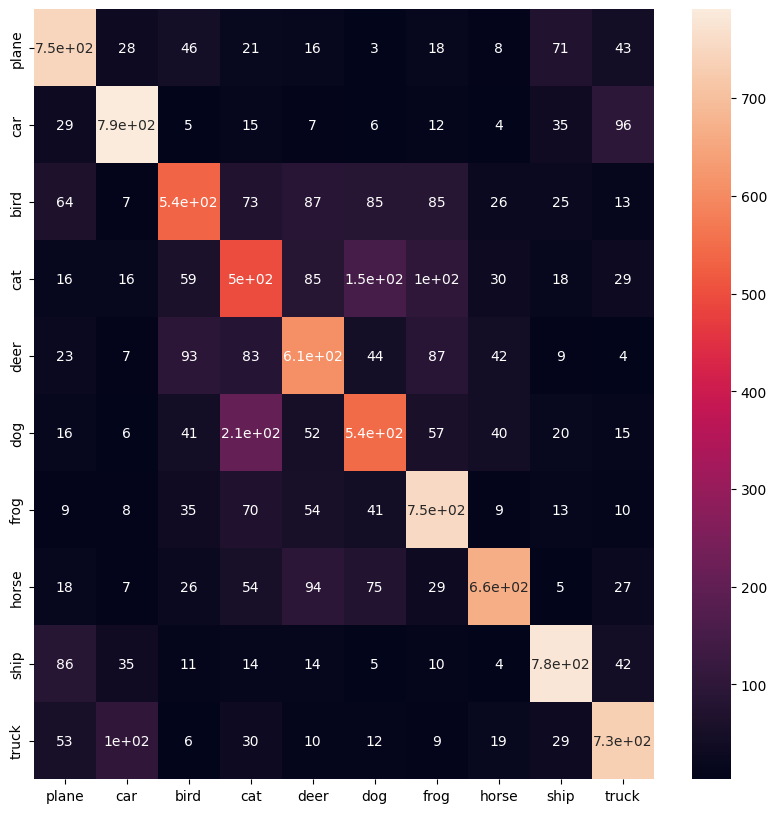

In [ ]:
# Predicciones por clase
y_pred = model_2.predict(test_images)
class_pred = np.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels_2, class_pred)
import seaborn as sns

plt.figure(figsize=(10, 10))
hm = sns.heatmap(confusion_matrix, annot=True)
hm.set(xticklabels = classes, yticklabels = classes)
plt.show()

# Resumen

In [ ]:
import pandas as pd

# Se crea un dataframe con los resultados de los modelos
results = pd.DataFrame({
    "Modelo": ["AlexNet (32x32)", "AlexNet (224x224)"],
    "Tiempo de entrenamiento (segundos)": [traintime_v1, traintime_v2],
    "Accuracy test": [acc_T1, acc_T2],
    "Loss test": [loss_T1, loss_T2]
})

results